# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
random_test = False

if random_test:
    for i in range(1, 6):                                      # play game for 5 episodes
        env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        while True:
            actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
            actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            scores += env_info.rewards                         # update the score (for each agent)
            states = next_states                               # roll over states to next time step
            if np.any(dones):                                  # exit loop if episode finished
                break
        print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

When finished, you can close the environment.

In [6]:
# Don't close the environment to use it for next experiments
# After close, it is impossible to reload environment on this Unity version.
# env.close()

### 4. Training Method

This is implementation of training method by using MADDPG.

#### 4.1. Import modules

In [7]:
import time
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
/Users/nicolasmakaroff/anaconda3/envs/drlnd/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


#### 4.2. Set device

In [8]:
# Set device between cuda:0 and cpu
torch_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device =', torch_device)

Device = cpu


#### 4.3. Define training method

In [9]:
def train(n_episodes=400, max_t=5000, agents=None, filenames=None,
          benchmark_score=30, rolling_n_episodes=10):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode (should be over 1000)
        agents (obj): training agent instances
        filenames (list): string of filenames to store weights of actor and critic
        benchmark_score (int): the score of agent should be over this score
        rolling_n_episodes (int): the score is checked whenever number of tries reachs to this
    """
    start_time = time.time()
        
    all_scores = []                                   # list containing scores from each episode for all agents
    scores_window = deque(maxlen=rolling_n_episodes)  # last rolling_n_episodes scores
    avg_checked = False
    max_score = -1
    
    for i_episode in range(1, n_episodes + 1):
        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
        states = env_info.vector_observations              # get the current state (for each agent)
        scores = np.zeros(len(agents))                     # initialize the score (for each agent)

        for agent in agents:                               # Reset agent before starting new episode
            agent.reset()

        for t in range(max_t):
            actions = [agent.act(states[i]) for i, agent in enumerate(agents)]  # select actions
            env_info = env.step(actions)[brain_name]       # send the action to the environment
            next_states = env_info.vector_observations     # get the next state
            rewards = env_info.rewards                     # get the reward
            dones = env_info.local_done                    # see if episode has finished

            for i, agent in enumerate(agents):
                agent.step(states[i], actions[i], rewards[i], next_states[i], dones[i])
            
            states = next_states                           # roll over the state to next time step
            scores += rewards                              # update the score
            if np.any(dones):                              # exit loop if episode finished
                break

        cur_score = np.max(scores)                         # average score of all agents
        scores_window.append(cur_score)                    # save most recent score
        all_scores.append(cur_score)                       # save all scores
        avg_scores_window = np.mean(scores_window)         # get average score of current window

        if cur_score > max_score and cur_score > 2.0:
            max_score = cur_score
            if filenames:
                for i, agent in enumerate(agents):
                    agent.store_actor_weights(filenames[0] + str(i) + '.pth')
                agent.store_critic_weights(filenames[1] + '.pth')

        print('\rEpisode {}\tAverage Score: {:.5f}\tScore: {:.5f}'.format(i_episode, avg_scores_window, cur_score), end="")
        
        if i_episode % rolling_n_episodes == 0:
            print('\rEpisode {}\tAverage Score: {:.5f}                '.format(i_episode, avg_scores_window))
        
        if not avg_checked and avg_scores_window >= benchmark_score:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.5f}'.format(
                  i_episode - rolling_n_episodes, avg_scores_window))
            avg_checked = True

    print('\nTraining time = {:.5f}s'.format(time.time() - start_time))

    return all_scores

#### 4.4. Define plot score method

In [10]:
import pandas as pd

def plot_scores(scores, benchmark_score, rolling_n_episodes):
    # plot the scores
    fig = plt.figure()
    ax = fig.add_subplot(111)

    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    ax.axhline(benchmark_score, c="red", alpha=0.5)
    
    rolling_window = rolling_n_episodes
    rolling_mean = pd.Series(scores).rolling(rolling_window).mean()
    plt.plot(rolling_mean, c='yellow', alpha=0.7)
    
    plt.show()

#### 4.5. Hyper-parameters for replay buffer

In [11]:
memory_params = {
    'buffer_size': int(1e6),        # replay buffer size
    'batch_size': 128,              # minibatch size
    'seed': 0,                      # Seed to generate random numbers
}

#### 4.6. Create replay buffer

In [12]:
# Create replay buffer
from replaybuffer import ReplayBuffer

memory = ReplayBuffer(action_size, memory_params['buffer_size'],
                      memory_params['batch_size'], memory_params['seed'], torch_device)

#### 4.7. Test trained agent
Below codes executes on Windows. It shows agents how to move by training result.

In [13]:
def test(agents, max_t=5000):
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    states = env_info.vector_observations              # get the current state
    scores = np.zeros(len(agents))

    for t in range(max_t):
        # select actions
        actions = [agent.act(states[i], add_noise=False) for i, agent in enumerate(agents)]
        env_info = env.step(actions)[brain_name]       # send the action to the environment
        rewards = env_info.rewards                     # get the reward
        dones = env_info.local_done                    # see if episode has finished
        states = env_info.vector_observations          # roll over the state to next time step
        scores += rewards                              # update the score
        if np.any(dones):                              # exit loop if episode finished
            break
    
    print('Score: {:.5f}'.format(np.max(scores)))

### 5. MADDPG
This is implementation of MADDPG.

#### 5.1. Set hyper-parameters

In [14]:
params = {
    'gamma': 0.99,                      # discount factor
    'tau': 0.15,                        # for soft update of target parameters
    'update_every': 1,                  # update parameters per this number
    'lr_actor': 7e-4,                   # learning rate of the Actor
    'lr_critic': 3e-3,                  # learning rate of the Critic
    'seed': 123,                          # Seed to generate random numbers
    'actor_units': [512, 256],          # Number of nodes in hidden layers of the Actor
    'critic_units': [512, 256],         # Number of nodes in hidden layers of the Critic
    'weight_decay': 0,                  # L2 weight decay
    'noise_theta': 0.15,                # Theta of Ornstein-Uhlenbeck process
    'noise_sigma': 0.01,                # Sigma of Ornstein-Uhlenbeck process
}

#### 5.2. Set plot parameters

In [15]:
# Parameters to store and plot scores
rolling_n_episodes = 10     # Score is checked whenever number of tries reachs to this.
benchmark_score = 0.5      # Score of agent should be over this score

#### 5.3. Set weight filenames

In [16]:
# Filenames of weights of Actor/Critic
actor_filename = 'model_maddpg_actor'
critic_filename = 'model_maddpg_critic'

#### 5.4. Create agents

In [17]:
from maddpg_agent import MADDPGAgent

maddpg_agents = [MADDPGAgent(state_size, action_size, memory, torch_device, params)
                 for _ in range(num_agents)]

#### 5.5. Training

In [18]:
maddpg_scores = train(150, 5000, maddpg_agents, [actor_filename, critic_filename],
                      benchmark_score, rolling_n_episodes)

Episode 10	Average Score: 0.01000                
Episode 20	Average Score: 0.02900                
Episode 30	Average Score: 0.02000                
Episode 40	Average Score: 0.03700                
Episode 50	Average Score: 0.10700                
Episode 60	Average Score: 0.10500                
Episode 70	Average Score: 0.12600                
Episode 80	Average Score: 0.11800                
Episode 90	Average Score: 0.14600                
Episode 100	Average Score: 0.23900                
Episode 102	Average Score: 0.51900	Score: 2.60000
Environment solved in 92 episodes!	Average Score: 0.51900
Episode 110	Average Score: 0.83000                
Episode 120	Average Score: 0.68800                
Episode 130	Average Score: 1.28000                
Episode 140	Average Score: 2.07000                
Episode 150	Average Score: 1.90000                

Training time = 4458.22673s


#### 5.6. Plot scores

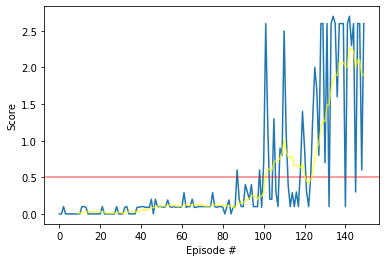

In [19]:
plot_scores(maddpg_scores, benchmark_score, rolling_n_episodes)

#### 5.7. Test

In [20]:
maddpg_agents = [MADDPGAgent(state_size, action_size, memory, torch_device, params)
                 for _ in range(num_agents)]

for i, agent in enumerate(maddpg_agents):
    agent.load_actor_weights(actor_filename + str(i) + '.pth')
    agent.load_critic_weights(critic_filename + '.pth')

test(maddpg_agents)

Score: 2.60000


#### 5.8. Close

In [21]:
env.close()